## Lexicase Selection Numba加速

DEAP中Lexicase Selection的默认实现速度较慢。因此，我们可以尝试使用Numba来加速它。
Numba的原理是将Python代码编译为LLVM中间代码，然后再编译为机器码。从而显著提高Python代码的运行速度。

In [3]:
import numpy as np
import math
import operator

from deap import base, creator, tools, gp
import time


# 符号回归
def evalSymbReg(individual, pset):
    # 编译GP树为函数
    func = gp.compile(expr=individual, pset=pset)
    
    # 使用numpy创建一个向量
    x = np.linspace(-10, 10, 100) 
    
    return tuple((func(x) - x**2)**2)


# 创建个体和适应度函数，适应度数组大小与数据量相同
creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * 100)  # 假设我们有100个数据点
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

### 遗传算子
在使用Numba进行对Lexicase加速时，只需要重写Lexicase函数，加上@njit(cache=True)这个注解就可以了。
需要注意一些特殊的函数可能不受Numba支持，但所有基本的Python运算符都是支持的。

In [4]:
from numba import njit
import numpy as np


@njit(cache=True)
def selAutomaticEpsilonLexicaseNumba(case_values, fit_weights, k):
    selected_individuals = []
    avg_cases = 0

    for i in range(k):
        candidates = list(range(len(case_values)))
        cases = np.arange(len(case_values[0]))
        np.random.shuffle(cases)

        while len(cases) > 0 and len(candidates) > 1:
            errors_for_this_case = np.array(
                [case_values[x][cases[0]] for x in candidates]
            )
            median_val = np.median(errors_for_this_case)
            median_absolute_deviation = np.median(
                np.array([abs(x - median_val) for x in errors_for_this_case])
            )
            if fit_weights > 0:
                best_val_for_case = np.max(errors_for_this_case)
                min_val_to_survive = best_val_for_case - median_absolute_deviation
                candidates = list(
                    [
                        x
                        for x in candidates
                        if case_values[x][cases[0]] >= min_val_to_survive
                    ]
                )
            else:
                best_val_for_case = np.min(errors_for_this_case)
                max_val_to_survive = best_val_for_case + median_absolute_deviation
                candidates = list(
                    [
                        x
                        for x in candidates
                        if case_values[x][cases[0]] <= max_val_to_survive
                    ]
                )
            cases = np.delete(cases, 0)
        avg_cases = (avg_cases * i + (len(case_values[0]) - len(cases))) / (i + 1)
        selected_individuals.append(np.random.choice(np.array(candidates)))
    return selected_individuals, avg_cases

def selAutomaticEpsilonLexicaseFast(individuals, k):
    fit_weights = individuals[0].fitness.weights[0]
    case_values = np.array([ind.fitness.values for ind in individuals])
    index, avg_cases = selAutomaticEpsilonLexicaseNumba(case_values, fit_weights, k)
    selected_individuals = [individuals[i] for i in index]
    return selected_individuals

在定义好了新的Lexicase选择算子之后，在注册选择算子的时候，将新的选择算子注册进去就可以了。

In [5]:
import random

# 定义函数集合和终端集合
pset = gp.PrimitiveSet("MAIN", arity=1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1, 1))
pset.renameArguments(ARG0='x')

# 定义遗传编程操作
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evalSymbReg, pset=pset)
toolbox.register("select", selAutomaticEpsilonLexicaseFast)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)

C:\Users\zhenl\anaconda3\Lib\site-packages\deap\gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


### 演化流程
演化流程与传统符号回归相同。

In [6]:
import numpy
from deap import algorithms

# 定义统计指标
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

# 使用Numba加速
numba_lexicase_time = []
for i in range(3):
    start = time.time()
    population = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    pop, log  = algorithms.eaSimple(population=population,
                               toolbox=toolbox, cxpb=0.9, mutpb=0.1, ngen=10, stats=mstats, halloffame=hof, verbose=True)
    end = time.time()
    print(str(hof[0]))
    numba_lexicase_time.append(end - start)


   	      	                        fitness                        	                      size                     
   	      	-------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max     	min	nevals	std    	avg	gen	max	min	nevals	std    
0  	100   	5275.44	0  	1.21e+06	0  	100   	42915.8	4  	0  	7  	2  	100   	1.54919
1  	91    	5008.21	1  	1.21e+06	0  	91    	52501.4	4.71	1  	14 	3  	91    	2.15543
2  	92    	8333.56	2  	1.21e+06	0  	92    	67566.8	4.61	2  	9  	3  	92    	1.88624
3  	89    	5219.06	3  	1.21e+06	0  	89    	52574.6	4.44	3  	13 	2  	89    	1.9252 
4  	89    	5054.56	4  	1.21e+06	0  	89    	52499.8	4.45	4  	11 	3  	89    	2.02176
5  	92    	8001.89	5  	1.21e+06	0  	92    	67135.2	4.58	5  	11 	3  	92    	2.04539
6  	85    	9893.52	6  	1.21e+06	0  	85    	73912.4	4.71	6  	10 	3  	85    	1.89365
7  	93    	5239.52	7  	1.21e+06	0  	93    	52304.6	4.62	7  	11 	3  	93    	1.9989 
8  	94    	130452 	8  	1.

为了展示Numba加速的效果，我们将使用纯Python实现的Lexicase Selection进行对比。

In [7]:
# 使用纯Python实现的Lexicase Selection
toolbox.register("select", tools.selAutomaticEpsilonLexicase)
python_lexicase_time = []
for i in range(3):
    start = time.time()
    population = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    pop, log  = algorithms.eaSimple(population=population,
                               toolbox=toolbox, cxpb=0.9, mutpb=0.1, ngen=10, stats=mstats, halloffame=hof, verbose=True)
    end = time.time()
    print(str(hof[0]))
    python_lexicase_time.append(end - start)

   	      	                        fitness                        	                      size                     
   	      	-------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max     	min	nevals	std    	avg 	gen	max	min	nevals	std    
0  	100   	3651.98	0  	1.21e+06	0  	100   	30493.7	4.67	0  	7  	2  	100   	1.74387
1  	90    	441.554	1  	44100   	0  	90    	2602.04	3.36	1  	9  	3  	90    	1.16207
2  	91    	293.089	2  	44100   	0  	91    	2139.02	3.25	2  	8  	3  	91    	0.876071
3  	90    	1726.19	3  	1.21e+06	0  	90    	30422  	3.28	3  	9  	3  	90    	1.0008  
4  	95    	4864.87	4  	1.21e+06	0  	95    	52507.2	3.43	4  	9  	3  	95    	1.21041 
5  	91    	145.704	5  	10000   	0  	91    	902.638	3.35	5  	9  	3  	91    	1.21963 
6  	84    	278.787	6  	40000   	0  	84    	1736.06	3.3 	6  	9  	2  	84    	1.09087 
7  	96    	1600.26	7  	1.21e+06	0  	96    	30392.7	3.08	7  	7  	3  	96    	0.483322
8  	84    	167.52

下面是Numba加速和纯Python实现的Lexicase Selection的运行时间对比。从结果可以看出，Numba加速后的Lexicase Selection的运行速度远优于纯Python实现的Lexicase Selection。

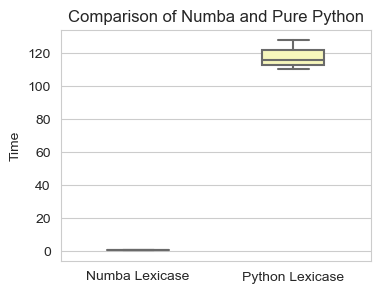

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = pd.DataFrame(
    {'Category': ['Numba Lexicase'] * len(numba_lexicase_time) + ['Python Lexicase'] * len(python_lexicase_time),
     'Time': np.concatenate([numba_lexicase_time, python_lexicase_time])})

plt.figure(figsize=(4, 3))
sns.set_style("whitegrid")
sns.boxplot(data=data, x='Category', y='Time', palette="Set3", width=0.4)
plt.title('Comparison of Numba and Pure Python')
plt.xlabel('')
plt.ylabel('Time')
plt.show()